In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from itertools import product
import torch.nn.functional as F
import pandas as pd

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
# sys.path.append(os.path.join(os.getcwd(), '../sympde/misc'))

from run import parse_options, main
# from tb_analysis import get_data, get_metrics, get_results
# from utils import get_dict_item
# from model.networks.linear import CalculatedP

In [3]:
args = parse_options(notebook=True)

args.net = 'Predict-NoneP'
args.data_dir = '../data/flower'
args.data_kwargs = {"space_length":"256","noise_std":"0.0","y_low":"2","y_high":"5"}

args.do_return = True
# args.persistent_workers = False
args.num_workers = 0

args.max_epochs = 30

args.train = False
args.test = False
args.version = 'version_0'
args.predict = True


# model, trainer, datamodule, preds = main(args)


In [9]:
y_trues = torch.load(os.path.join(args.log_dir, 'symlieflat_dataflower_netPredict-NoneP_lr-3.00_seed42', args.version, 'y_trues.pt'))
y_preds = torch.load(os.path.join(args.log_dir, 'symlieflat_dataflower_netPredict-NoneP_lr-3.00_seed42', args.version, 'y_preds.pt'))

1.0057798624038696


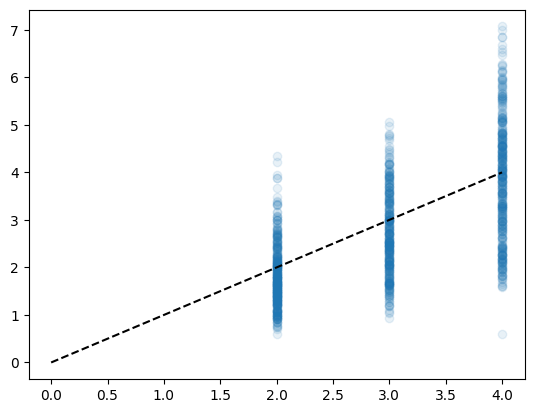

In [11]:
# def stack_preds(preds):
#     y_trues, y_preds = zip(*preds)
#     return torch.cat(y_trues), torch.cat(y_preds)

# y_trues, y_preds = stack_preds(preds)

# y_trues.shape, y_preds.shape

mse_loss = F.mse_loss(y_preds, y_trues)
print(mse_loss.item())

l = 4
plt.plot(y_trues, y_preds, 'o', alpha = 0.1)
plt.plot([0, l], [0,l], 'k--')
plt.show()

# Run_twice

In [ ]:
# lrs = torch.logspace(-7, -1, 7)
lrs = [1e-1]

seeds = torch.arange(1,8)

P_preds = {}
for seed, lr in product(seeds, lrs):

    args = parse_options(notebook=True)
    args.net = 'TrainP'

    args.train = False
    args.do_return = True
    args.version = 'version_0'

    args.lr = lr
    args.seed = seed

    args.n_splits = [10_000, 1_000, 1_000]

    model, trainer, datamodule, _ = main(args)

    # Visualize and save the predicted P matrix
    P_pred = model.net.P.data.clone()
    P_pred = model.net.normalize_P(P_pred)

    P_preds[seed.item()] = P_pred

    plt.figure(figsize = (3,3))
    plt.imshow(P_pred)
    plt.show()

In [ ]:
x, y, eps = batch = next(iter(datamodule.test_dataloader()))

In [ ]:
out_a, out_b = model(batch)
print('Output NOT allclose!' if not torch.allclose(out_a, out_b) else 'pass')
out_a, out_b

In [ ]:
seeds = [1]

nets = ['Predict-NoneP', 'Predict-CalculatedP', 'Predict-TrainedP']

for seed, net in product(seeds, nets):
    args = parse_options(notebook=True)

    args.net = net
    args.seed = seed

    if net == 'Predict-TrainedP':
        args.P_pred = P_preds[seed.item()]

    model, trainer, datamodule, _ = main(args)


In [ ]:
data = get_data(filter = 'symlieflat')
data = get_results(data, metrics = ['test_loss'])

In [ ]:
df = pd.DataFrame()

for k, v in data.items():
    _, _, net, _, seed, _, _ = k.split('_')
    net = net.split('-')[-1]
    seed = int(seed.replace('seed', ''))

    test_loss = v['test_loss']
    if len(test_loss) == 0:
        print(net, seed)
        test_loss = [np.nan]
    assert len(set(test_loss)) == 1, test_loss
    test_loss = test_loss[0]

    df.at[seed, net] = test_loss
df

In [ ]:
df = df[['NoneP', 'CalculatedP', 'TrainedP']]

In [ ]:
fig, axs = plt.subplot_mosaic("AAA;BCD", figsize = (8,6), tight_layout = True, gridspec_kw = dict(height_ratios = [0.5, 1]))

ax = axs['A']

for i, (seed, vals) in enumerate(df.iterrows()):
    ax.plot(vals, label = seed, marker = None, ls = '--', alpha = 0.1, color = 'k')

net_colors = {'NoneP': 'C0', 'CalculatedP': 'C1', 'TrainedP': 'C2'}

for i, (net, test_losses) in enumerate(df.T.iterrows()):
    vals = test_losses.values
    ax.scatter(np.full_like(vals, i), vals, alpha = 0.5, marker = 'x', color = net_colors[net])

ax.set_xticks(np.arange(len(df.T)), df.T.index)
ax.set_ylabel('Test loss')

calculated_Ps = {k: v() for k, v in CalculatedP(size=7).transform_funcs.items()}

P_none = calculated_Ps['none']
P_calculated = calculated_Ps['space_translation']
P_pred = P_preds[1]

P_plots = [P_none, P_calculated, P_pred]

for i, (P, ax_i) in enumerate(zip(P_plots, ['B', 'C', 'D'])):
    ax = axs[ax_i]
    ax.imshow(P)
    # ax.set_axis_off()
    ax.patch.set_edgecolor(list(net_colors.values())[i])

    ax.patch.set_linewidth(5)  

    # Disable ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
P_preds_tensor = torch.stack(list(P_preds.values()))

plt.hist( P_preds_tensor.numpy().flatten(), bins = 100, alpha = 0.5, label = 'Trained P')
plt.show()

In [ ]:
plt.figure(figsize = (3,3))
plt.imshow( torch.std(P_preds_tensor, dim = 0) )
plt.colorbar()
plt.show()


plt.figure(figsize = (3,3))
plt.imshow( torch.mean(P_preds_tensor, dim = 0) )
plt.colorbar()
plt.show()

In [ ]:

args = parse_options(notebook=True)

args.net = 'Predict-CalculatedP'
args.seed = 1

args.train = False
args.test = False
args.version = 'version_0'
args.predict = True

model, trainer, datamodule, preds = main(args)


In [ ]:
def stack_preds(preds):
    y_preds, y_trues = [], []
    for y_true, y_pred in preds:
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = torch.cat(y_trues)
    y_preds = torch.cat(y_preds)

    return y_trues, y_preds

In [ ]:
mse_loss = F.mse_loss(y_preds, y_trues)
mse_loss.item()

In [ ]:
l = 4
plt.plot(y_trues, y_preds, 'o', alpha = 0.5)
plt.plot([0, l], [0,l], 'k--')